# Book Recommendation System

<img src="images/book.jpg">

Recommendation systems are widely used today to recommend products to users based on their interests. A recommendation system is one of the strongest systems for increasing profits by retaining more users in a very big competition. In this project, I’ll walk you through how to build a book recommendation system with Machine Learning using the Python programming language.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_column', 100)

In [3]:
df = pd.read_csv('data/books.csv',error_bad_lines = False)

Skipping line 3350: expected 12 fields, saw 13
Skipping line 4704: expected 12 fields, saw 13
Skipping line 5879: expected 12 fields, saw 13
Skipping line 8981: expected 12 fields, saw 13



## EDA - Exploratory Data Analysis

In [4]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [5]:
df.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [6]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


## Data Visualization

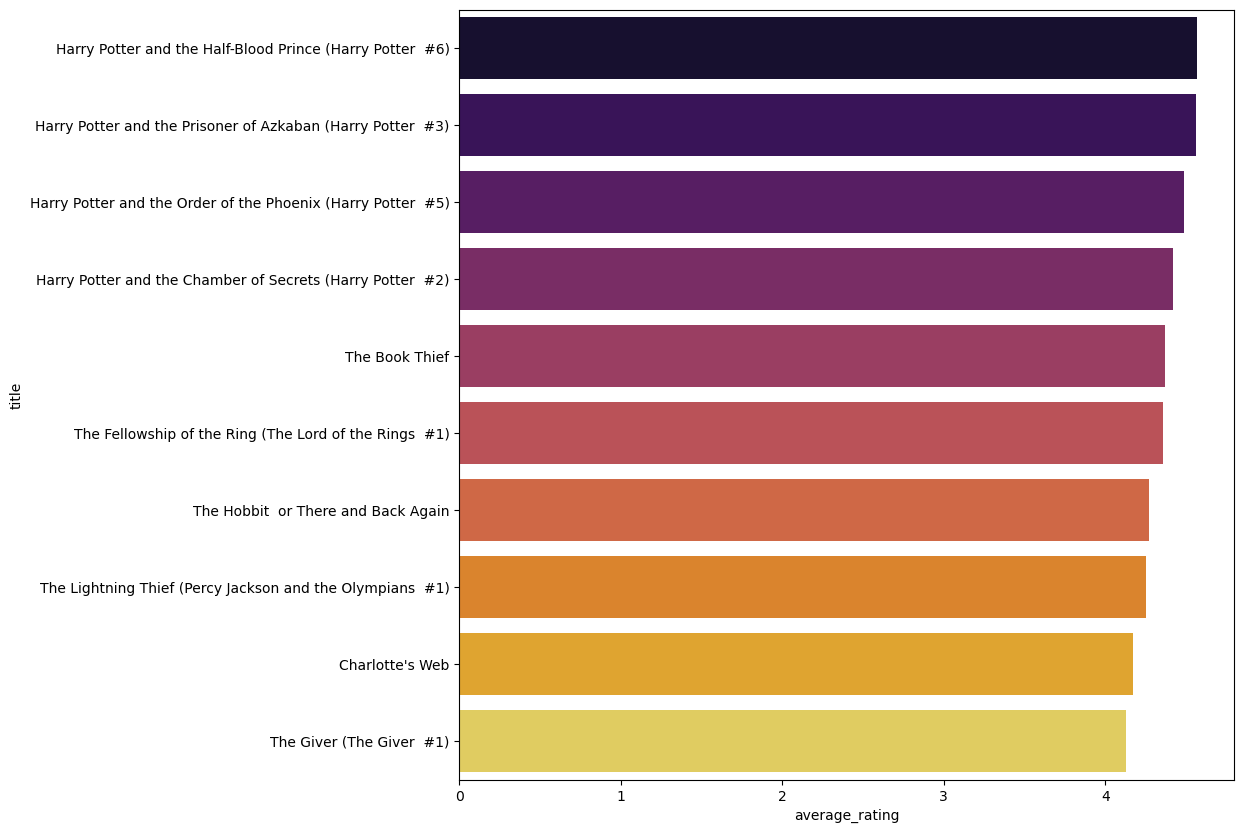

In [9]:
top_ten = df[df['ratings_count'] > 1000000]
top_ten.sort_values(by='average_rating', ascending=False)

plt.figure(figsize=(10, 10))
data = top_ten.sort_values(by='average_rating', ascending=False).head(10)
sns.barplot(x="average_rating", y="title", data=data, palette='inferno');

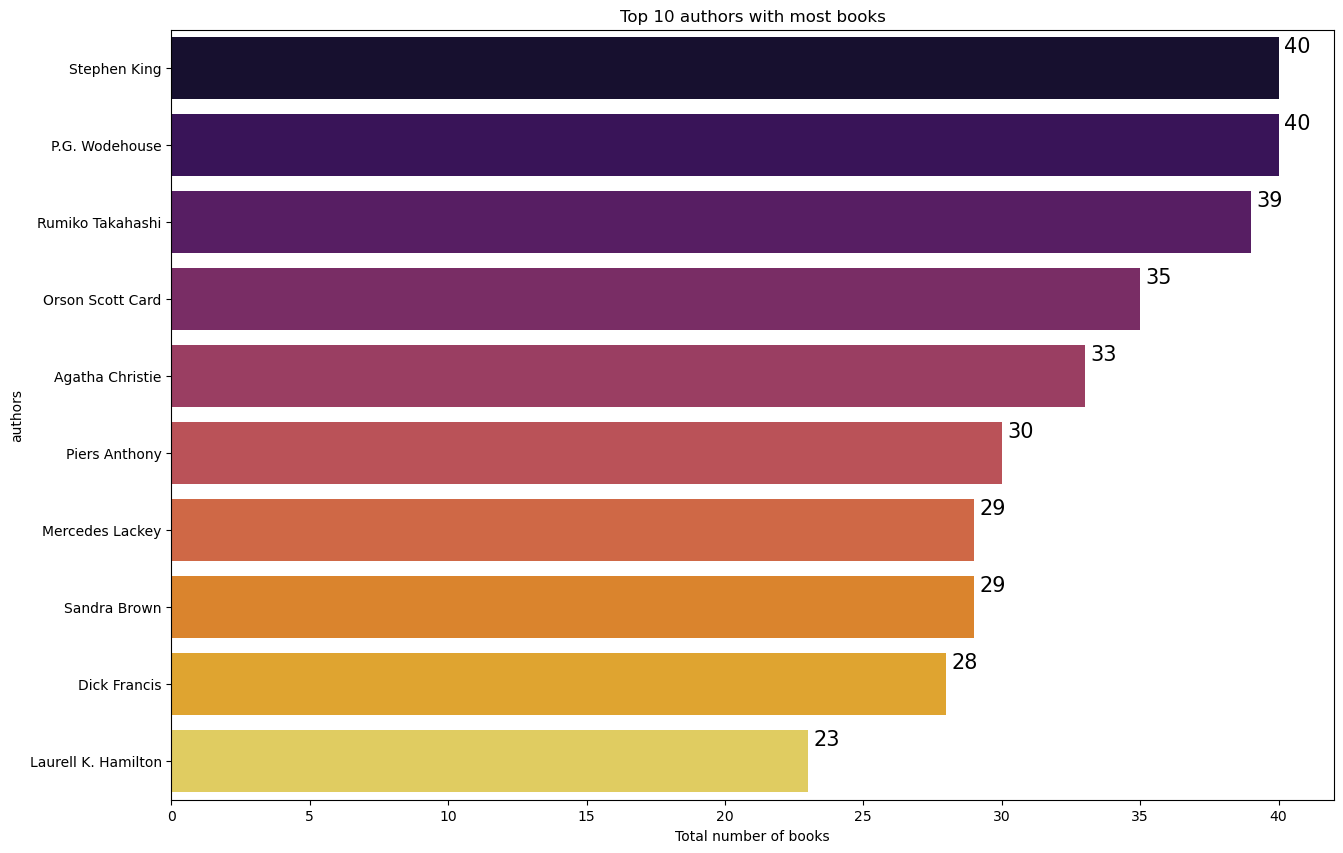

In [14]:
most_books = df.groupby('authors')['title'].count().reset_index().sort_values('title', ascending=False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(x=most_books['title'] ,y=most_books.index, palette='inferno')
ax.set_title("Top 10 authors with most books")
ax.set_xlabel("Total number of books")
totals = []
for i in ax.patches:
    totals.append(i.get_width())  
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.2, i.get_y()+.2,str(round(i.get_width())), fontsize=15,color='black')
plt.show();

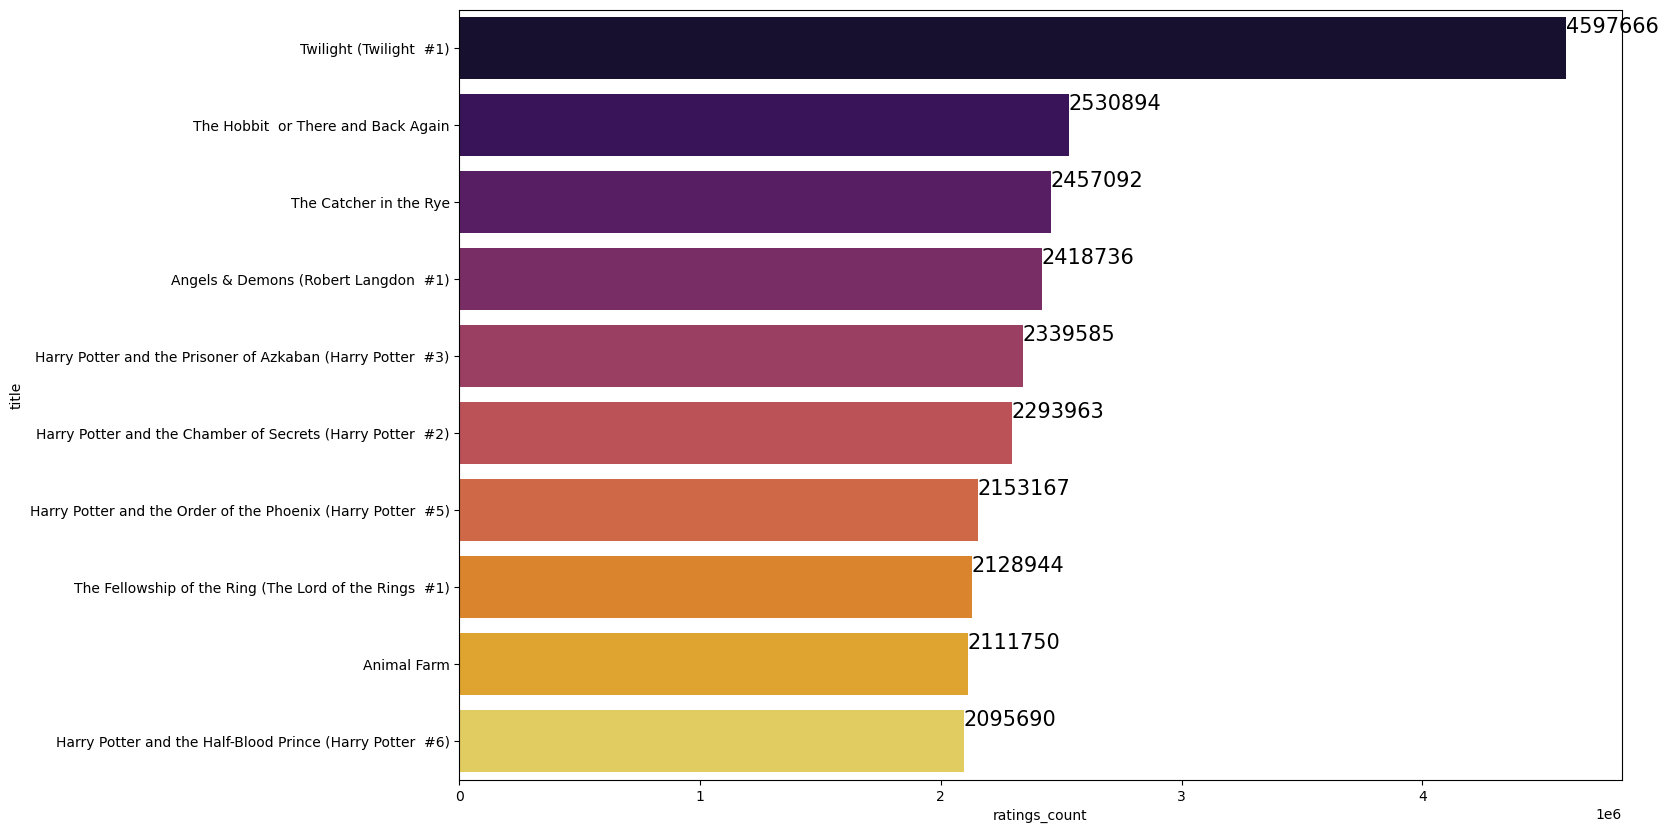

In [16]:
most_rated = df.sort_values('ratings_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(15,10))
ax = sns.barplot(x=most_rated['ratings_count'], y=most_rated.index, palette = 'inferno')
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.2, i.get_y()+.2,str(round(i.get_width())), fontsize=15,color='black')
plt.show();

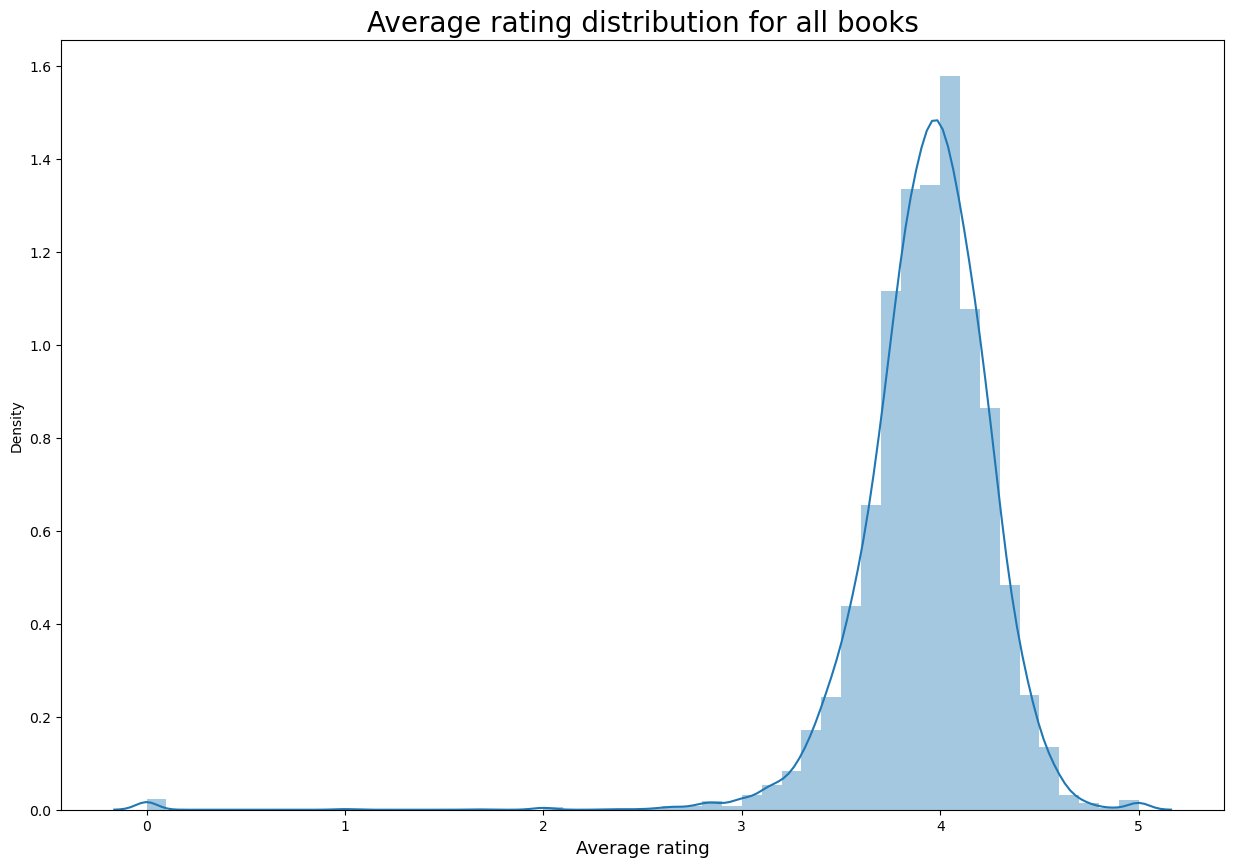

In [18]:
df.average_rating = df.average_rating.astype(float)
fig, ax = plt.subplots(figsize=[15,10])
sns.distplot(df['average_rating'],ax=ax)
ax.set_title('Average rating distribution for all books',fontsize=20)
ax.set_xlabel('Average rating',fontsize=13);

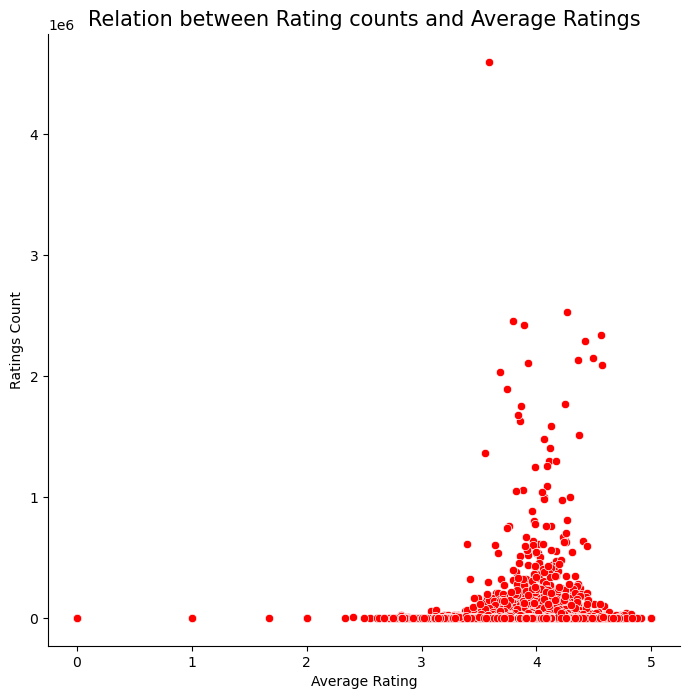

In [29]:
ax = sns.relplot(data=df, x="average_rating", y="ratings_count", color = 'red', sizes=(100, 200), height=7, marker='o')
plt.title("Relation between Rating counts and Average Ratings",fontsize = 15)
ax.set_axis_labels("Average Rating", "Ratings Count");

<Figure size 1500x1000 with 0 Axes>

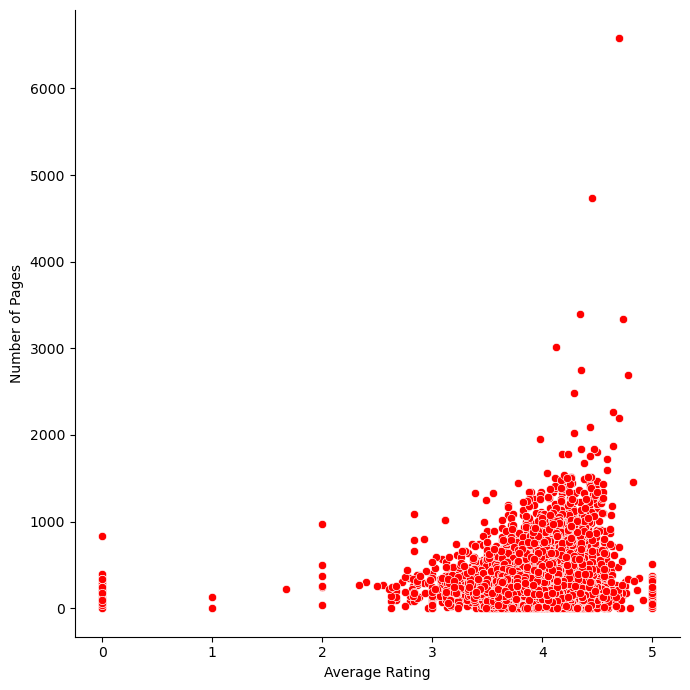

In [30]:
plt.figure(figsize=(15,10))
ax = sns.relplot(x="average_rating", y="  num_pages", data = df, color = 'red',sizes=(100, 200), height=7, marker='o')
ax.set_axis_labels("Average Rating", "Number of Pages");

## Data Preparation

In [21]:
df2 = df.copy()

In [22]:
df2.loc[ (df2['average_rating'] >= 0) & (df2['average_rating'] <= 1), 'rating_between'] = "between 0 and 1"
df2.loc[ (df2['average_rating'] > 1) & (df2['average_rating'] <= 2), 'rating_between'] = "between 1 and 2"
df2.loc[ (df2['average_rating'] > 2) & (df2['average_rating'] <= 3), 'rating_between'] = "between 2 and 3"
df2.loc[ (df2['average_rating'] > 3) & (df2['average_rating'] <= 4), 'rating_between'] = "between 3 and 4"
df2.loc[ (df2['average_rating'] > 4) & (df2['average_rating'] <= 5), 'rating_between'] = "between 4 and 5"

In [23]:
rating_df = pd.get_dummies(df2['rating_between'])
language_df = pd.get_dummies(df2['language_code'])

In [24]:
features = pd.concat([rating_df, 
                      language_df, 
                      df2['average_rating'], 
                      df2['ratings_count']], axis=1)

## Final Step

In [25]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

In [26]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(features)
dist, idlist = model.kneighbors(features)

In [27]:
def BookRecommender(book_name):
    book_list_name = []
    book_id = df2[df2['title'] == book_name].index
    book_id = book_id[0]
    for newid in idlist[book_id]:
        book_list_name.append(df2.loc[newid].title)
    return book_list_name
    
BookNames = BookRecommender('Harry Potter and the Half-Blood Prince (Harry Potter  #6)')
BookNames

['Harry Potter and the Half-Blood Prince (Harry Potter  #6)',
 'Harry Potter and the Order of the Phoenix (Harry Potter  #5)',
 'The Fellowship of the Ring (The Lord of the Rings  #1)',
 'Harry Potter and the Chamber of Secrets (Harry Potter  #2)',
 'Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)',
 'The Lightning Thief (Percy Jackson and the Olympians  #1)']